# Importing Dependencies

In [39]:
# Dealing with dataframe
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [40]:
customer_data = pd.read_csv('Online Retail.csv')
customer_data.shape

(541909, 8)

In [41]:
customer_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [42]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [43]:
# dropping missing values 
customer_data = customer_data.dropna()

In [44]:
customer_data['InvoiceDate'] = pd.to_datetime(customer_data['InvoiceDate'])

In [45]:
customer_data["InvoiceDate"] = customer_data["InvoiceDate"].dt.date

In [46]:
# Removing negative values from 'Quantity' and 'UnitPrice'

customer_data =  customer_data[~(customer_data[['Quantity', 'UnitPrice']] < 0).any(axis=1)].copy()

In [47]:
# Derived feature 'Total_Amount' gives the total amount for item purchased by a customer 

customer_data['Total_Amount'] = customer_data['Quantity'] * customer_data['UnitPrice'] 

In [161]:
# Finding the the time period of the data

print (f"The report contains data from {min(customer_data.InvoiceDate)} to {max(customer_data.InvoiceDate)} which is a total of {(max(customer_data.InvoiceDate)- min(customer_data.InvoiceDate)).days} days")

The report contains data from 2010-12-01 to 2011-12-09 which is a total of 373 days


In [48]:
# Creating a snapshot_date variable to store (the most recent observation + 1) day to create recency using invoice date varaiable while grouping customer data
# The plus 1 is used to get snapshot_date so that the recency value for the most recent customers are stored as 1 and not 0

import datetime
snapshot_date = max(customer_data.InvoiceDate) + datetime.timedelta(days=1)

snapshot_date

datetime.date(2011, 12, 10)

In [49]:
# Grouping customer data by 'CustomerID' so that information about unique customer can be aggregated 

customers = customer_data.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days, 'InvoiceNo': 'count','Total_Amount': 'sum'})

In [50]:
# Renaming columns with appropriate column names 

customers.rename(columns = {'InvoiceDate': 'Recency','InvoiceNo': 'Purchase_Frequency',
                            'Total_Amount': 'Amount_Spent'}, inplace=True)

In [51]:
customer_new = customers[customers['Amount_Spent'] != 0].copy()

In [52]:
customer_new.describe()

,Recency,Purchase_Frequency,Amount_Spent
count,4338.000000,4338.000000,4338.000000
mean,93.059474,91.729599,2054.266460
std,100.012264,228.815081,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,307.415000
50%,51.000000,41.000000,674.485000
75%,142.750000,100.000000,1661.740000
max,374.000000,7847.000000,280206.020000


**In the new derived table we have more concrete and interpratable information about each of our customers with the following derived features**
- **Recency :** Number of days it has been since the customers last purchase
- **Purchase_Frequency :** The number of time the cutsomer has made a purchase
- **Amount_Spent :** The total amount a customer has spent

# Exploratory Data Analysis

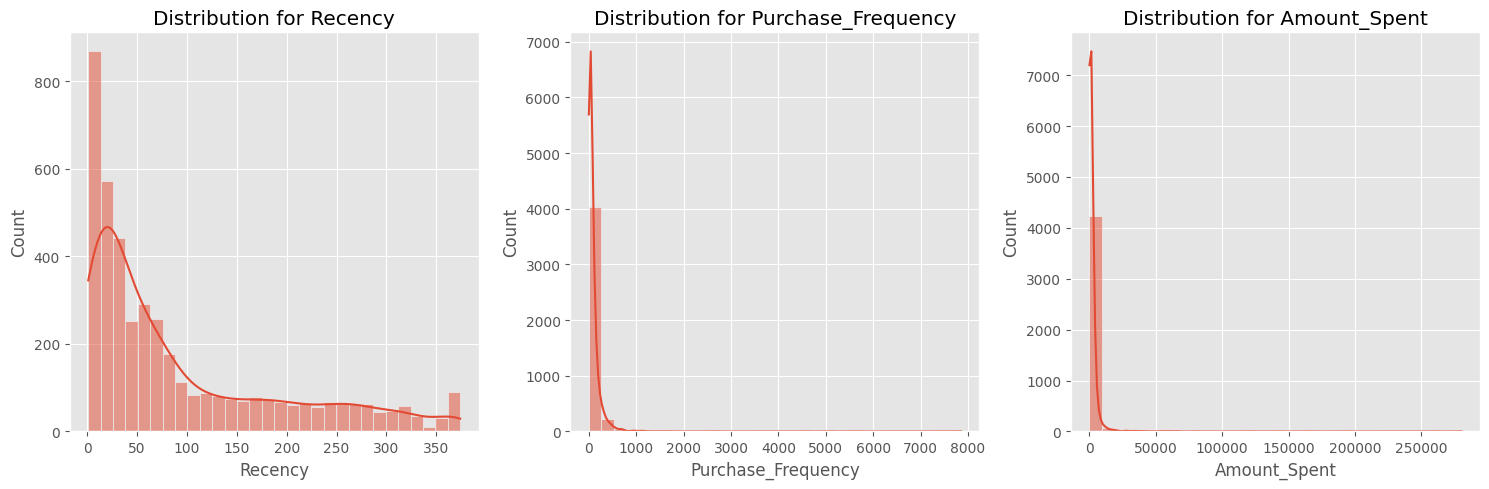

In [53]:
# Checking data distribution 
feature = ['Recency','Purchase_Frequency','Amount_Spent']

plt.figure(figsize=(15,5))

for i in enumerate(feature):
    plt.subplot(1,3, i[0]+1)
    ax = sns.histplot(customer_new[i[1]], kde = True, bins=30)
    ax.set_title(f"Distribution for {i[1]}")
plt.tight_layout()
plt.show()

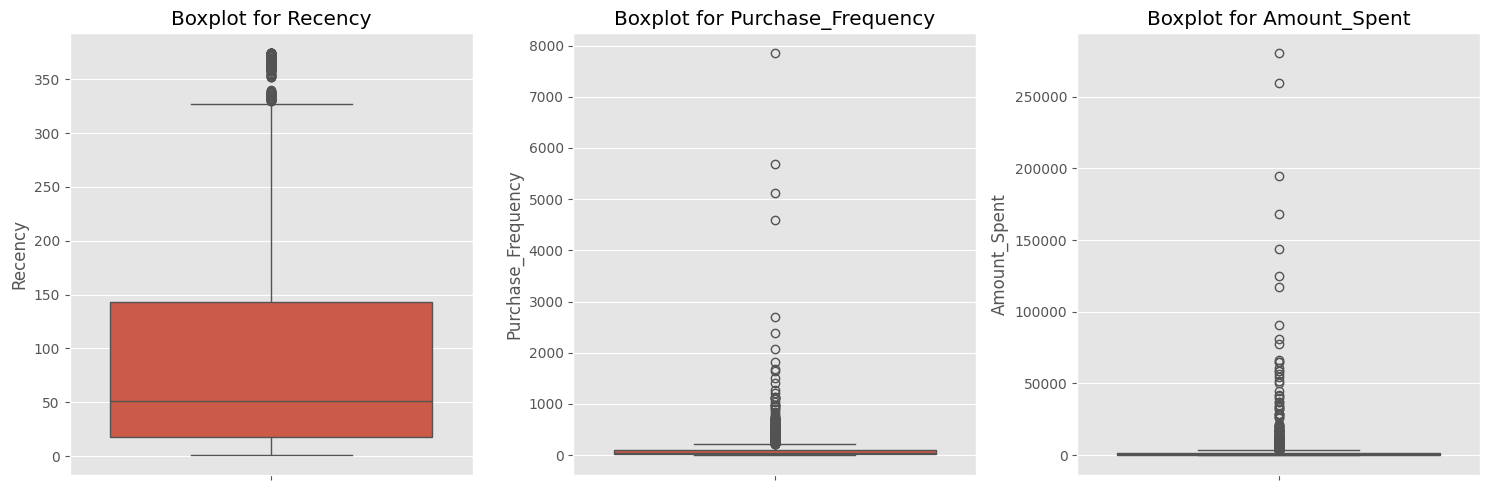

In [54]:
plt.figure(figsize=(15,5))

for i in enumerate(feature):
    plt.subplot(1,3, i[0]+1)
    ax = sns.boxplot(customer_new[i[1]])
    ax.set_title(f"Boxplot for {i[1]}")
plt.tight_layout()
plt.show()

# Capping Outliers

In [55]:
def outlier_cap(to_cap):
    for i in to_cap:
        Q3, Q1 = np.percentile(customer_new[i], [75,25])
        IQR = Q3-Q1
        up_lim = Q3 + 1.5 * IQR
        low_lim = Q1 - 1.5 * IQR

        outlier = ((customer_new[i] < low_lim) | (customer_new[i] > up_lim)).sum()

        print(f"{i} has {outlier} outliers.")

        customer_new[i] = np.where(customer_new[i]>up_lim, up_lim,
                        np.where(customer_new[i]<low_lim,low_lim,customer_new[i]))

        print(f"{outlier} values in {i} has been capped with {up_lim:.2f} for high outliers and {low_lim:.2f} for low outliers."'\n')

In [56]:
outlier_cap(feature)

Recency has 155 outliers.
155 values in Recency has been capped with 329.88 for high outliers and -169.12 for low outliers.

Purchase_Frequency has 380 outliers.
380 values in Purchase_Frequency has been capped with 224.50 for high outliers and -107.50 for low outliers.

Amount_Spent has 427 outliers.
427 values in Amount_Spent has been capped with 3693.23 for high outliers and -1724.07 for low outliers.



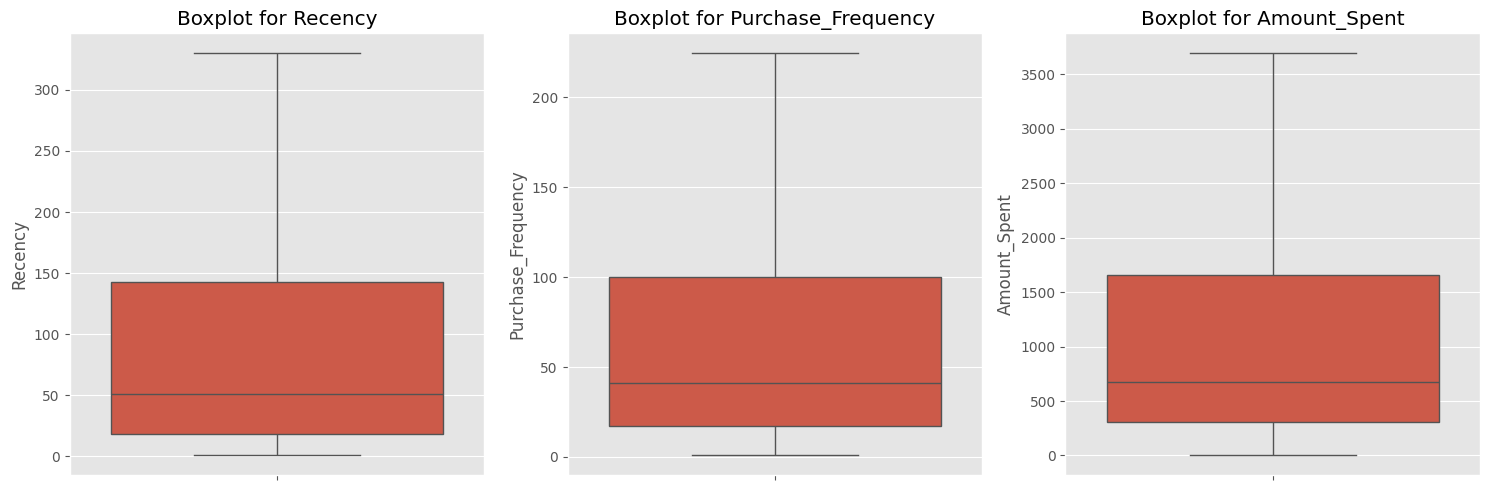

In [57]:
plt.figure(figsize=(15,5))

for i in enumerate(feature):
    plt.subplot(1,3, i[0]+1)
    ax = sns.boxplot(customer_new[i[1]])
    ax.set_title(f"Boxplot for {i[1]}")
plt.tight_layout()
plt.show()

# Feature Scaling with standardization

In [58]:
from sklearn.preprocessing import StandardScaler
scaling = StandardScaler()

In [59]:
customer_scaled = customer_new.copy()

customer_scaled['Recency'] = scaling.fit_transform(customer_new[['Recency']])
customer_scaled['Purchase_Frequency'] = scaling.fit_transform(customer_new[['Purchase_Frequency']])
customer_scaled['Amount_Spent'] = scaling.fit_transform(customer_new[['Amount_Spent']]) 

In [60]:
customer_scaled.describe()

,Recency,Purchase_Frequency,Amount_Spent
count,4.338000e+03,4.338000e+03,4.338000e+03
mean,8.189750e-19,5.937569e-17,7.206980e-17
std,1.000115e+00,1.000115e+00,1.000115e+00
min,-9.354037e-01,-9.906585e-01,-1.009777e+00
25%,-7.606945e-01,-7.576863e-01,-7.452462e-01
50%,-4.215532e-01,-4.082282e-01,-4.254819e-01
75%,5.213626e-01,4.508565e-01,4.345418e-01
max,2.444448e+00,2.263671e+00,2.204224e+00


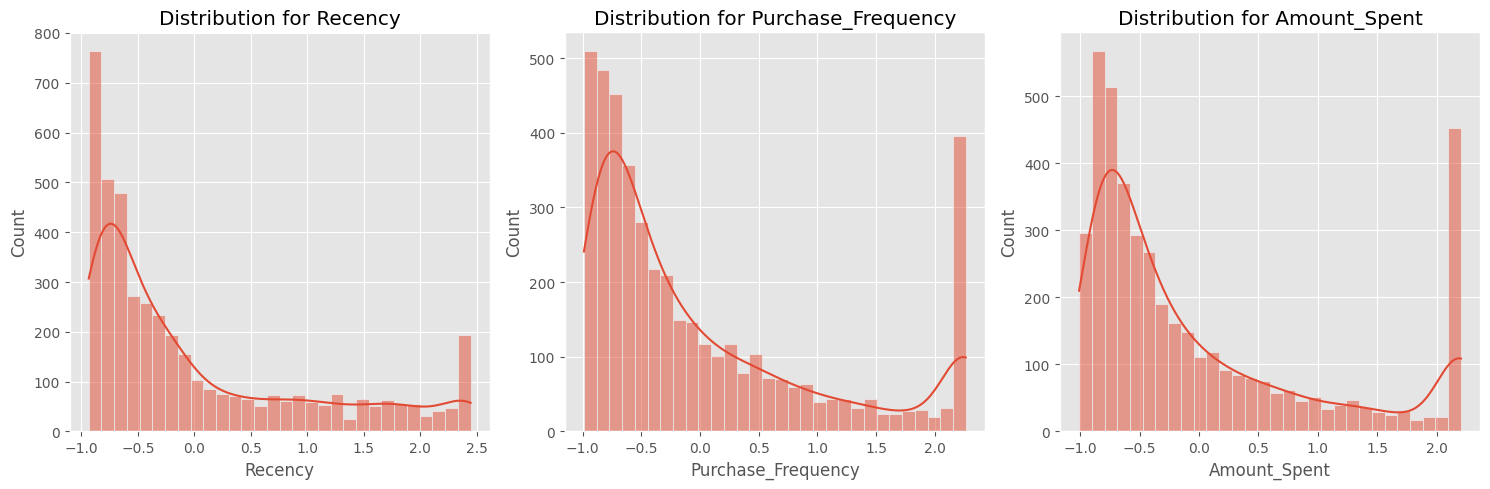

In [61]:
plt.figure(figsize=(15,5))

for i in enumerate(feature):
    plt.subplot(1,3, i[0]+1)
    ax = sns.histplot(customer_scaled[i[1]], kde = True, bins=30)
    ax.set_title(f"Distribution for {i[1]}")
plt.tight_layout()
plt.show()

# K-Means Clustering

In [172]:
from sklearn.cluster import KMeans

In [173]:
wcss = {}
for i in range(1,11):
    km = KMeans(n_clusters=i)
    km.fit_predict(customer_new)
    wcss[i]= km.inertia_

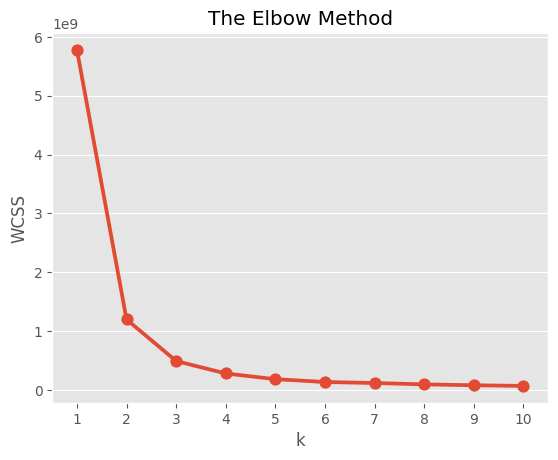

In [174]:
ax= sns.pointplot(x = list(wcss.keys()),y = list(wcss.values()))
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.show()

In [175]:
x = customer_new.values
km = KMeans(n_clusters = 3, random_state= 101)

In [176]:
km.fit(x)

KMeans(n_clusters=3, random_state=101)

In [177]:
customer_new['cluster'] = km.labels_

In [178]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

score = silhouette_score(x, customer_new['cluster'])
db = davies_bouldin_score(x, customer_new['cluster'])
ch = calinski_harabasz_score(x, customer_new['cluster'])

print("Silhouette score:", score)
print("Davies-Bouldin Index:", db)
print("Calinski-Harabasz Index:", ch)

Silhouette score: 0.648591903157298
Davies-Bouldin Index: 0.48479773013986627
Calinski-Harabasz Index: 23265.846491103337


In [179]:
customer_new.head()

,Recency,Purchase_Frequency,Amount_Spent,cluster
CustomerID,,,,
12346.0,326.0,1.0,3693.2275,1
12347.0,3.0,182.0,3693.2275,1
12348.0,76.0,31.0,1797.2400,0
12349.0,19.0,73.0,1757.5500,0
12350.0,311.0,17.0,334.4000,2


# Cluster Visualization

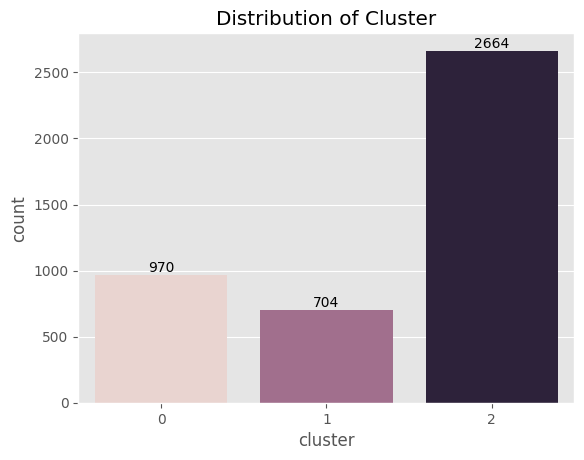

In [180]:
ax = sns.countplot(customer_new, x = 'cluster', hue='cluster', legend=False)
for i in ax.containers:
    ax.bar_label(i)
ax.set_title("Distribution of Cluster")
plt.show()

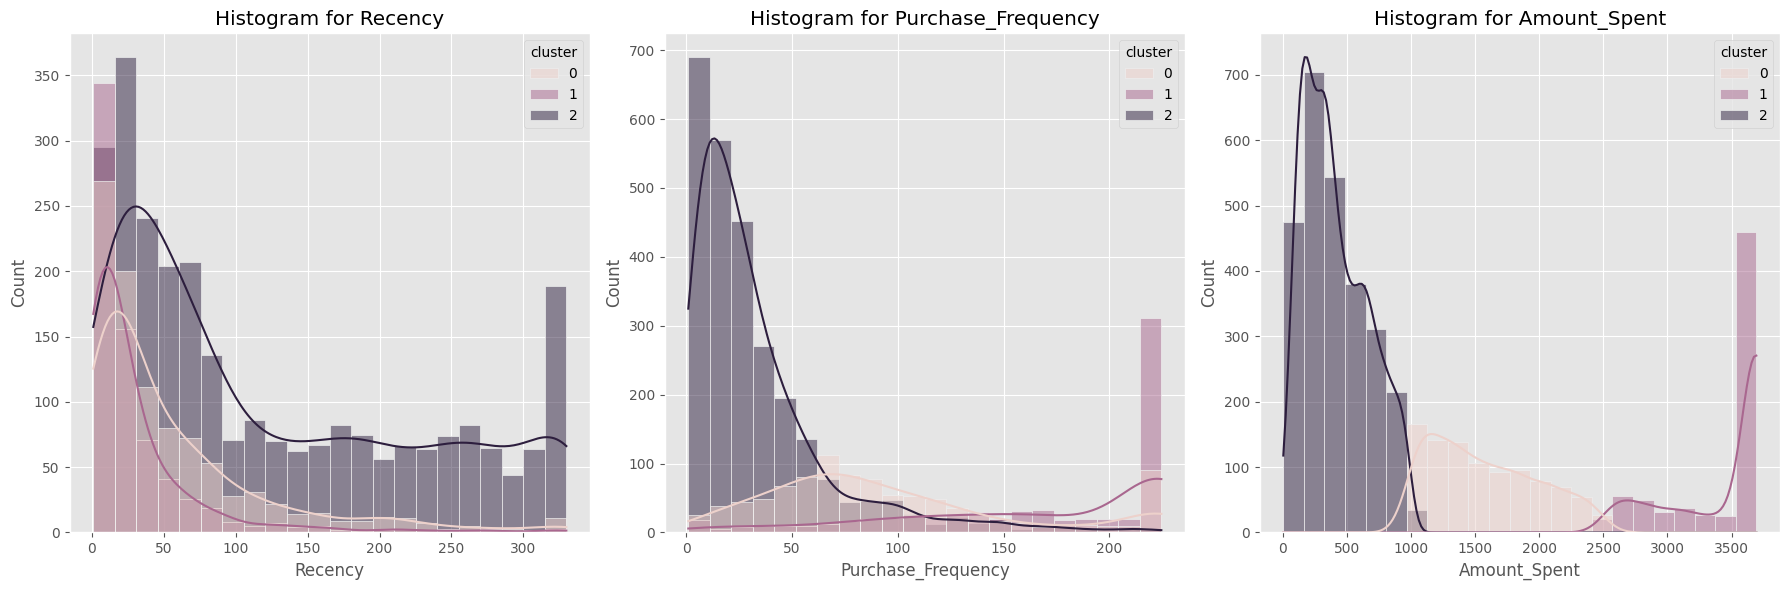

In [181]:
feature = ['Recency','Purchase_Frequency','Amount_Spent']

plt.figure(figsize=(18,6))

for i in enumerate(feature):
    plt.subplot(1,3, i[0]+1)
    ax = sns.histplot(customer_new, x= i[1], hue = 'cluster', kde = 'True')
    ax.set_title(f"Histogram for {i[1]}")

plt.tight_layout()
plt.show()

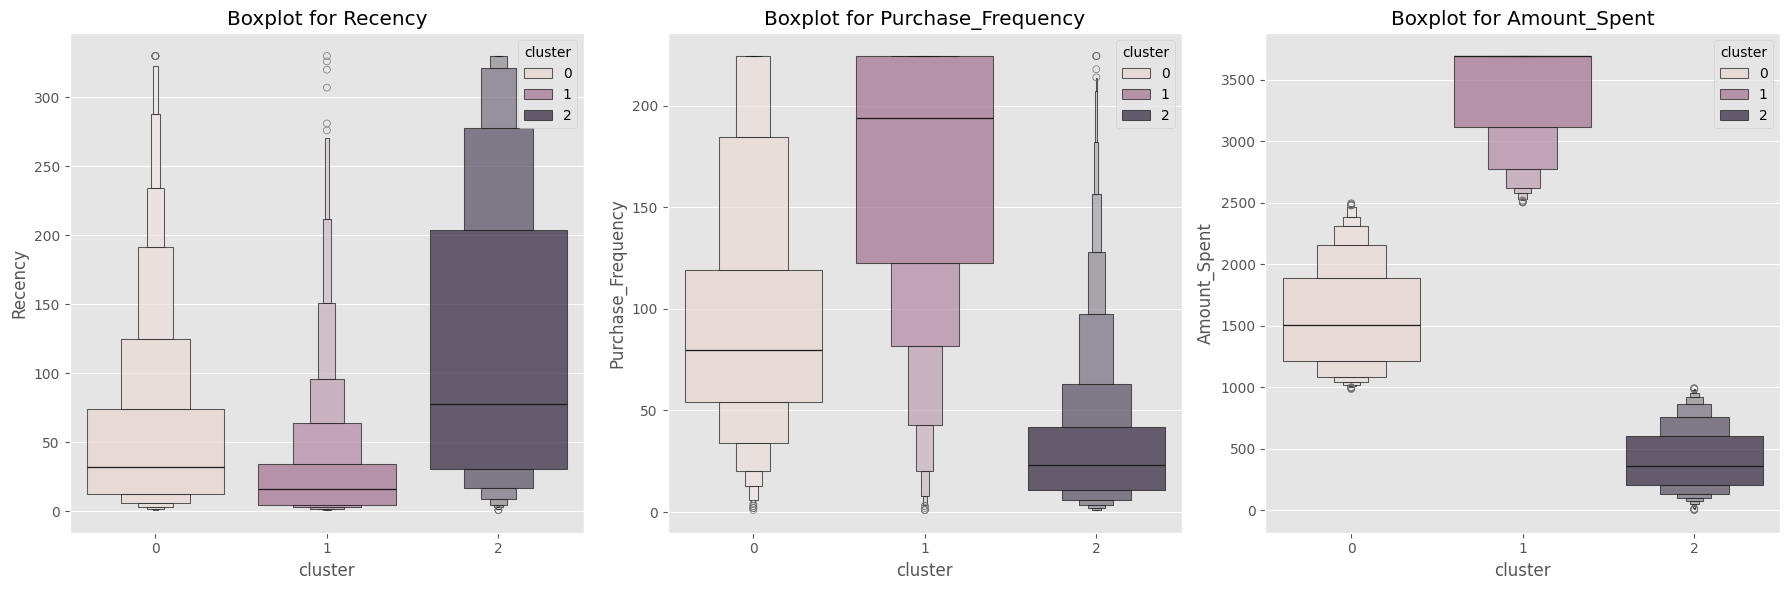

In [182]:
plt.figure(figsize=(18,6))

for i in enumerate(feature):
    plt.subplot(1,3, i[0]+1)
    ax = sns.boxenplot(x=customer_new['cluster'], y=customer_new[i[1]],  hue=customer_new['cluster'], alpha=0.7)
    ax.set_title(f"Boxplot for {i[1]}")

plt.tight_layout()
plt.show()

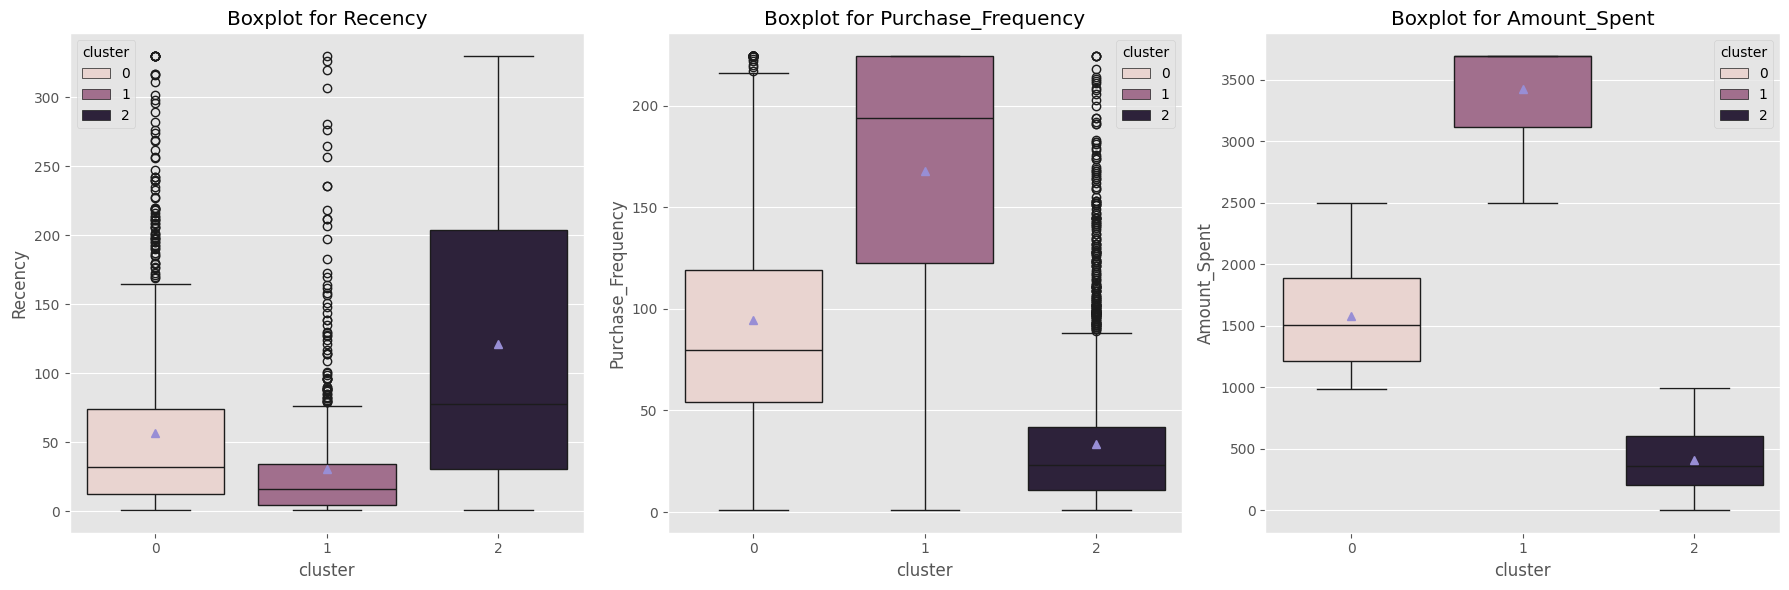

In [183]:
plt.figure(figsize=(18,6))

for i in enumerate(feature):
    plt.subplot(1,3, i[0]+1)
    ax = sns.boxplot(x=customer_new['cluster'], y=customer_new[i[1]],  hue=customer_new['cluster'], showmeans = True)
    ax.set_title(f"Boxplot for {i[1]}")

plt.tight_layout()
plt.show()

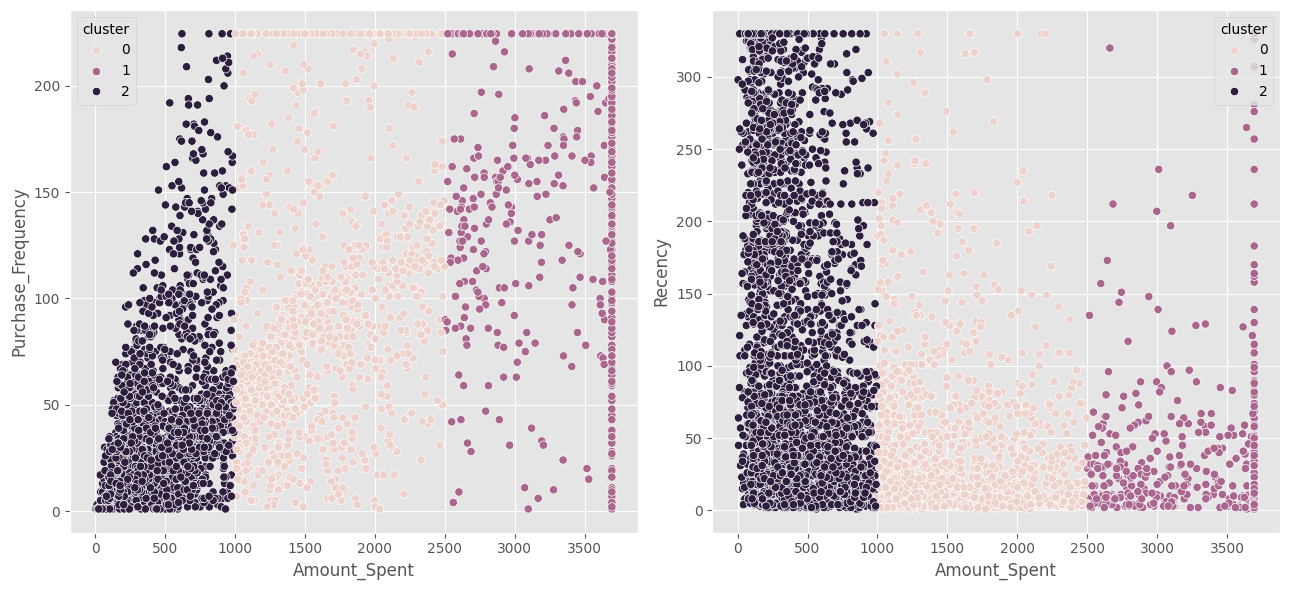

In [184]:
figure, (ax1,ax2) = plt.subplots(1,2, figsize=(13,6))

sns.scatterplot(customer_new, x = 'Amount_Spent', y = 'Purchase_Frequency', hue='cluster', ax = ax1)

sns.scatterplot(customer_new, x = 'Amount_Spent', y = 'Recency', hue='cluster', ax = ax2)

plt.tight_layout()
plt.show()

<center><h1 "font-weight: bold; font-family: Cursive">
Cluster Observation</h1></center>    

**Cluster 0**
- There are 976 unique customers in this cluster 
- This group of customers are in the middle of heard in Recency, frequency and amount spent  
- The customer in this cluster have spent on average a total of $1500 a year
- On average the customer of this cluster made a purchase 55 days ago from the final date of record
- Throughout the year the customers in this cluster makes 90 different transaction on average

**Cluster 1**
- There are 704 unique customers in this cluster 
- This group of customers are mosts loyal ones with low Recency and high frequency and amount spent  
- The customer in this cluster have spent on average a more than of $3400 a year
- On average the customer of this cluster made a purchase 30 days ago from the final date of record
- Throughout the year the customers in this cluster makes 170 different transactions on average

**Cluster 2**
- There are 2664 unique customers in this cluster
- This group of customers are in the lower end with high Recency, and low frequency and amount spent  
- The customer in this cluster on avg spend less than $500 a year
- On average the customer of this cluster made a purchase 125 days ago from the final date of record
- Throughout the year the customers in this cluster makes 30 different transaction on average

**Cluster Nature**
- In the cluster 0 are the customer that are fairly repatative but need more effective targeting and strategies to transform to loyal customers

- Cluster 1 is the ideal loyal customer with high purchase and ferquency who most likely will contnue spending and do not need much targeting

- Cluster 2 is the most problematic cluster where customer retention is likely to be low and the churn rate is likely to be high. Strong and effective strategies must be kept in place to get these customer slowly transform them into loyal customers. Further, detailed examination of this cluster is rquired to detrmine any necessary action for the purpose of the business.

# Exploring a few more model for clustering 

# DBSCAN

In [93]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=3)

In [94]:
y_lbl = dbscan.fit_predict(x)

In [95]:
score = silhouette_score(x, y_lbl)
db = davies_bouldin_score(x, y_lbl)
ch = calinski_harabasz_score(x, y_lbl)

print("Silhouette score:", score)
print("Davies-Bouldin Index:", db)
print("Calinski-Harabasz Index:", ch)

Silhouette score: 0.5124535393925451
Davies-Bouldin Index: 0.3059262753930306
Calinski-Harabasz Index: 55.81098659050135


# K-Medoids Clustering

In [103]:
from sklearn_extra.cluster import KMedoids

In [146]:
Kmed = KMedoids(n_clusters = 3, random_state= 101)

In [147]:
Kmed.fit(x)

KMedoids(n_clusters=3, random_state=101)

In [148]:
customer_new['cluster'] = Kmed.labels_

In [149]:
score = silhouette_score(x, customer_new['cluster'])
db = davies_bouldin_score(x, customer_new['cluster'])
ch = calinski_harabasz_score(x, customer_new['cluster'])

print("Silhouette score:", score)
print("Davies-Bouldin Index:", db)
print("Calinski-Harabasz Index:", ch)

Silhouette score: 0.6392076721049347
Davies-Bouldin Index: 0.5002676602413151
Calinski-Harabasz Index: 22700.2056197247


**Conclusion** 
- Both K-Means clustering and K-medoids have given us an acceptable shilhouette score but DBSCAN does not show to be a good fit for this particular dataset
- K-Means clustering is the best fit model for this particular dataset